# Spiral ODE

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/Crown421/GPDiffEq.jl/blob/main/examples/spiral/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/AbstractGPs.jl/dev/examples/spiral/).*

## Setup

Load necessary packages

In [1]:
using ApproximateGPs
using Plots
using LinearAlgebra
using DifferentialEquations
using InducingPoints
using GPDiffEq

First we define an ODE and generate some data points from it.

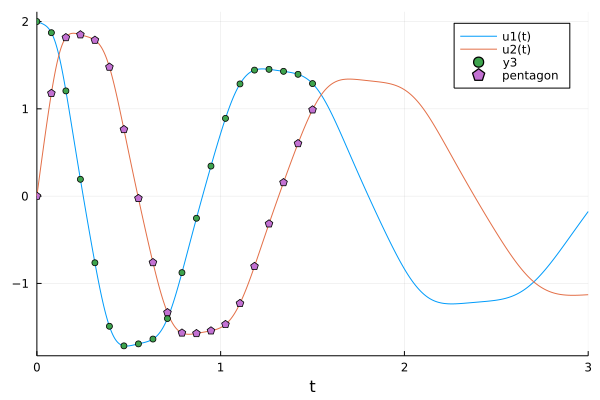

In [2]:
u0 = [2.0; 0.0]
datasize = 20
tspan = (0.0, 3.0)
datatspan = (0.0, 1.5)
datatsteps = range(datatspan[1], datatspan[2]; length=datasize)

function trueODEfunc(u, p, t)
    du = similar(u)
    true_A = [-0.1 2.0; -2.0 -0.1]
    return du .= ((u .^ 3)'true_A)'
end

prob_trueode = ODEProblem(trueODEfunc, u0, tspan)
sol = solve(prob_trueode, Tsit5())
ode_data = Array(sol(datatsteps))

traj = sol(datatsteps);

p = plot(sol)
scatter!(p, datatsteps, ode_data[1, :]; markersize=4)#, markerstyle = :star)
scatter!(p, datatsteps, ode_data[2, :]; m=(4, :pentagon), lab="pentagon")#, markerstyle = :star)

## Gradient data
For this example we get gradient observations from our trajectory data via finite differences

First, we set all necessary variables

In [3]:
scaker = with_lengthscale(SqExponentialKernel(), 1.0)
moker = IndependentMOKernel(scaker)
##ToDo: make ODE data into col_vecs and add number programmatically
x = MOInput(datatsteps, 2)
σ_n = 1e-6
y = ode_data'[:]
nothing #hide

and build a finite GP from them

In [4]:
g = GP(moker)
gt = g(x, σ_n)
nothing #hide

Now we use the following convenience functions to a loglikelihood loss function and a function to rebuild the gp with the optimal parameters.
Note that we use optimize over the logarithm of the parameters, to ensure their positivity. For more details see [this KernelFunctions.jl example](https://juliagaussianprocesses.github.io/KernelFunctions.jl/dev/examples/train-kernel-parameters/)

In [5]:
loss, buildgppost = gp_negloglikelihood(gt, x, y)

p0 = log.([1.0])
unfl(x) = exp.(x)
optp = gp_train(loss ∘ unfl, p0; show_trace=true, show_every=15)
optparams = unfl(optp)

1-element Vector{Float64}:
 7.160713088339386

Now we can build a FiniteGP with the optimized parameters,

In [6]:
optpost = buildgppost(optparams)
nothing #hide

which fits pretty well

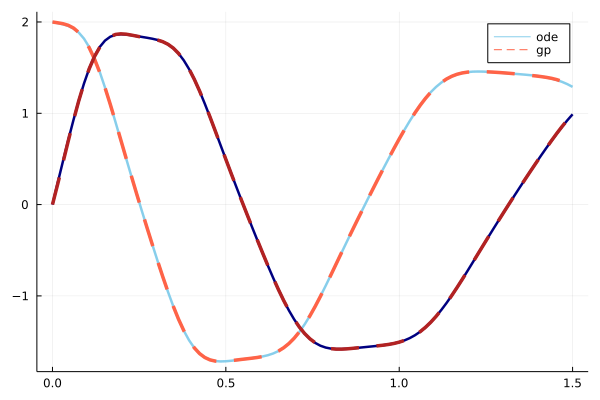

In [7]:
t_plot = range(datatspan...; length=100)
plot(sol(t_plot); label=["ode" ""], color=[:skyblue :navy], linewidth=2.5)
t_plot_mo = MOInput(t_plot, 2)
pred_mean = mean(optpost, t_plot_mo)
pred_mean = reshape(pred_mean, :, 2)
# pred_cov = diag(cov(optpost, t_plot_mo))
# pred_cov = reshape(pred_cov, :, 2)
# plot!(t_plot, pred_mean; ribbons = pred_cov)
plot!(
    t_plot,
    pred_mean;
    label=["gp" ""],
    color=[:tomato :firebrick],
    linewidth=3.5,
    linestyle=:dash,
)

GPs are closed under linear operators, which means that we can very easily obtain derivative information:

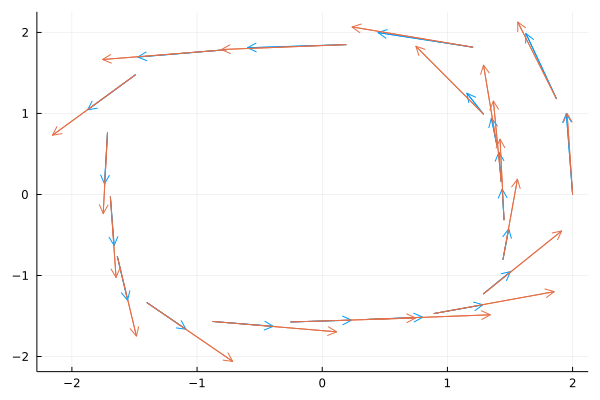

In [8]:
deriv_post = build_deriv_model(optpost)
du_pred_mean = mean(deriv_post, x)
du_pred_mean = reshape(du_pred_mean, :, 2)
du_pred_mean = du_pred_mean ./ norm.(eachrow(du_pred_mean))

du = trueODEfunc.(eachcol(ode_data), 0, 0)
du = du ./ maximum(norm.(du))
quiver(ode_data[1, :], ode_data[2, :]; quiver=(getindex.(du, 1), getindex.(du, 2)))
quiver!(ode_data[1, :], ode_data[2, :]; quiver=(du_pred_mean[:, 1], du_pred_mean[:, 2]))

This leaves us with `u` and `udot` pairs as in the input and output:

In [9]:
u = ColVecs(ode_data)
udot = ColVecs(du_pred_mean')

20-element KernelFunctions.ColVecs{Float64, LinearAlgebra.Adjoint{Float64, Matrix{Float64}}, SubArray{Float64, 1, LinearAlgebra.Adjoint{Float64, Matrix{Float64}}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, false}}:
 [-0.043711303483780516, 0.9990442042010698]
 [-0.310482241639859, 0.9505791800930042]
 [-0.9679885818073968, 0.25099423397860116]
 [-0.9981745514937379, -0.060395072235034826]
 [-0.9925640431588979, -0.12172354015580261]
 [-0.6641107188284132, -0.7476342375367839]
 [-0.034397323590253395, -0.9994082369731737]
 [0.045578854731326744, -0.9989607439741467]
 [0.1531189470772444, -0.9882077656272268]
 [0.6867685284040238, -0.7268761850506394]
 [0.9917569391235823, -0.128133421480202]
 [0.9987719487914493, 0.04954386245874081]
 [0.9983253771890384, 0.05784843351694462]
 [0.9627106801116336, 0.2705330781974648]
 [0.62712952663302, 0.7789149869048895]
 [0.11581090255516366, 0.9932712795854708]
 [-0.03217748787311947, 0.9994821705634248]
 [-0.06244417281112426, 0.998048458383627]


## Building a model
Now we build a model for the the ODE.

In [10]:
scaker = with_lengthscale(SqExponentialKernel(), ones(2))
moker = IndependentMOKernel(scaker)

u_mo = MOInput(u, 2)
σ_n = 1e-6
y = reduce(vcat, udot.X)
nothing #hide

and build a posterior GP

In [11]:
gpmodel = GP(moker)
fin_gpmodel = gpmodel(u_mo, σ_n)
post_gpmodel = posterior(fin_gpmodel, y)

AbstractGPs.PosteriorGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.IndependentMOKernel{KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.ARDTransform{Vector{Float64}}}}}, NamedTuple{(:α, :C, :x, :δ), Tuple{Vector{Float64}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, KernelFunctions.MOInputIsotopicByOutputs{SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, KernelFunctions.ColVecs{Float64, Matrix{Float64}, SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}}}, Vector{Float64}}}}(AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.IndependentMOKernel{KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.ARDTransform{Vector{Float64}}}}}(AbstractGPs.ZeroMean{Float64}(), Independent Multi-Output Kernel
	Squared Exponential Kernel (metric = Distances.Euclidean(0.0))
	- ARD

and optimize

In [12]:
loss, buildgppost = gp_negloglikelihood(fin_gpmodel, u_mo, y)

p0 = log.(ones(2))
unfl(x) = exp.(x)
optp = gp_train(loss ∘ unfl, p0)
optparams = unfl(optp)

2-element Vector{Float64}:
 0.659898864802357
 1.34902131688504

We build a posterior GP with the optimized parameters,

In [13]:
optpost = buildgppost(optparams)
nothing #hide

and incorporate into a GP ode model. Unfortunately, this does not currently match the previous implementation.

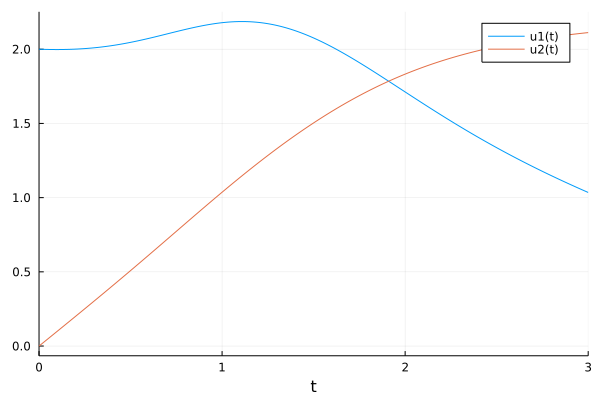

In [14]:
gpode = GPODE(optpost, tspan)
gpsol = gpode(u0)

plot(gpsol)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*